# Machine Learning para imóveis
Vamos fazer um programa para auxiliar novos inscritos a definirem valor de seus imóveis antes de anunciarem. Bastará informar as características do imóvel que pretende ser vendido que o programa recomendará o valor.

### Importar bibliotecas necessárias

In [82]:
import os
import pandas as pd
import numpy as np
import collections as clt
import statsmodels.api as sm
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn

### Definindo caminhos e arquivos

In [7]:
git_path = "/".join( os.getcwd().split("\\")[:-1] )
data_path = git_path + "/data/"

### Importação da base de dados

In [10]:
imovel_file = "imovel_csv.csv"
imovel_df = pd.read_csv(data_path+imovel_file, sep=";")
imovel_df.head(3)

,caracteristicas,cep,codigo,descricao,endereço,estado,latitude,longitude,qtde_banheiros,qtde_quartos,qtde_vagas,rua,txt_descricao,url,valor_cond,valor_iptu,valor_venda
0,"Interfone, Piscina, Academia, Salão de festas,...",4112012.0,COD. 75291f,"Apartamento na Vila Mariana, Próximo a Metrô e...","Avenida Lins de Vasconcelos, 757 - Vila Marian...",SP,-23.570246,-46.622185,2.0,3.0,2.0,"Avenida Lins de Vasconcelos, 757","A 10 minutos do metrô Ana Rosa, 13 minutos de ...",https://www.vivareal.com.br/imovel/apartamento...,R$ 650,R$ 2.200,R$ 660.000
1,"Sistema de alarme, Quadra poliesportiva, Playg...",4139000.0,COD. ALA135,Apartamento para venda Vila Mariana - 93m² - ...,"Rua Pageú, 107 - Vila Mariana, São Paulo - SP",SP,-23.606243,-46.635422,3.0,3.0,2.0,"Rua Pageú, 107",Excelente apto a venda a 700 metros do metro P...,https://www.vivareal.com.br/imovel/apartamento...,R$ 750,R$ 1.800,R$ 900.000
2,"Interfone, Sacada, Segurança 24h, Salão de fes...",4141001.0,COD. 0460,Apartamento à venda com 3 Dorms / 97 m² na Vl ...,"Rua Guiratinga, 923 - Vila Mariana, São Paulo ...",SP,-23.609918,-46.630977,3.0,3.0,2.0,"Rua Guiratinga, 923",WIDE VILA MARIANA\n\nTorre única\n97 m²\n3 dor...,https://www.vivareal.com.br/imovel/apartamento...,R$ 800,R$ 1.900,R$ 850.000


### Verificando dados faltantes

In [11]:
imovel_df.count()

caracteristicas    4674
cep                4862
codigo             5071
descricao          5071
endereço           5071
estado             5071
latitude           5071
longitude          5071
qtde_banheiros     4907
qtde_quartos       5066
qtde_vagas         4958
rua                4435
txt_descricao      5051
url                5071
valor_cond         4591
valor_iptu         3923
valor_venda        5071
dtype: int64

### Removendo linhas que não tem CEP

In [12]:
imovel_df = imovel_df[np.isfinite( imovel_df["cep"]) ]
imovel_df["cep"] = imovel_df["cep"].astype(int)
imovel_df.head(3)

,caracteristicas,cep,codigo,descricao,endereço,estado,latitude,longitude,qtde_banheiros,qtde_quartos,qtde_vagas,rua,txt_descricao,url,valor_cond,valor_iptu,valor_venda
0,"Interfone, Piscina, Academia, Salão de festas,...",4112012,COD. 75291f,"Apartamento na Vila Mariana, Próximo a Metrô e...","Avenida Lins de Vasconcelos, 757 - Vila Marian...",SP,-23.570246,-46.622185,2.0,3.0,2.0,"Avenida Lins de Vasconcelos, 757","A 10 minutos do metrô Ana Rosa, 13 minutos de ...",https://www.vivareal.com.br/imovel/apartamento...,R$ 650,R$ 2.200,R$ 660.000
1,"Sistema de alarme, Quadra poliesportiva, Playg...",4139000,COD. ALA135,Apartamento para venda Vila Mariana - 93m² - ...,"Rua Pageú, 107 - Vila Mariana, São Paulo - SP",SP,-23.606243,-46.635422,3.0,3.0,2.0,"Rua Pageú, 107",Excelente apto a venda a 700 metros do metro P...,https://www.vivareal.com.br/imovel/apartamento...,R$ 750,R$ 1.800,R$ 900.000
2,"Interfone, Sacada, Segurança 24h, Salão de fes...",4141001,COD. 0460,Apartamento à venda com 3 Dorms / 97 m² na Vl ...,"Rua Guiratinga, 923 - Vila Mariana, São Paulo ...",SP,-23.609918,-46.630977,3.0,3.0,2.0,"Rua Guiratinga, 923",WIDE VILA MARIANA\n\nTorre única\n97 m²\n3 dor...,https://www.vivareal.com.br/imovel/apartamento...,R$ 800,R$ 1.900,R$ 850.000


### Importação da base de ceps

In [13]:
cep_file = "cep_sp.csv"
cep_df = pd.read_csv(data_path+cep_file, sep=",")
cep_df["cep"] = cep_df["cep"].astype(int)
cep_df.head(3)

,Unnamed: 0,cep,logradouro,bairro,IdCidade,IdEstado
0,0,1001000,"Praça da Sé, lado ímpar",Sé,8966,26
1,1,1001001,"Praça da Sé, lado par",Sé,8966,26
2,2,1001010,Rua Filipe de Oliveira,Sé,8966,26


### Join entre as bases

In [14]:
imovel_df = pd.merge(left=imovel_df, right=cep_df[["cep", "bairro"]], how="left", on="cep", copy=False)

### Tratamento das características

In [15]:
carac_list = []
for i in imovel_df["caracteristicas"]:
    if type(i) == str:
        carac_list += i.lower().replace(" ", "").split(",")

In [16]:
carac_serie = pd.Series( clt.Counter( carac_list ) ).sort_values()
carac_serie / imovel_df.shape[0]
carac_serie = carac_serie[carac_serie>100  ]

In [17]:
def carac_column( x, carac_str ):
    try:
        if carac_str in x:
            return 1
        else:
            return 0
    except TypeError as err:
        return 0

    
imovel_df["new_caracteristicas"] = imovel_df["caracteristicas"].apply(lambda x: x.lower().replace(" ", "") if type(x)==str else np.nan)

for i in carac_serie.index:
    imovel_df[i] = imovel_df["new_caracteristicas"].apply( func=carac_column, args=[i] )    
    

In [18]:
imovel_df.head(3)

,caracteristicas,cep,codigo,descricao,endereço,estado,latitude,longitude,qtde_banheiros,qtde_quartos,...,jardim,áreadeserviço,churrasqueira,academia,playground,salãodefestas,sacada,interfone,piscina,elevador
0,"Interfone, Piscina, Academia, Salão de festas,...",4112012,COD. 75291f,"Apartamento na Vila Mariana, Próximo a Metrô e...","Avenida Lins de Vasconcelos, 757 - Vila Marian...",SP,-23.570246,-46.622185,2.0,3.0,...,1,0,1,1,1,1,0,1,1,1
1,"Sistema de alarme, Quadra poliesportiva, Playg...",4139000,COD. ALA135,Apartamento para venda Vila Mariana - 93m² - ...,"Rua Pageú, 107 - Vila Mariana, São Paulo - SP",SP,-23.606243,-46.635422,3.0,3.0,...,1,0,1,1,1,1,1,1,1,1
2,"Interfone, Sacada, Segurança 24h, Salão de fes...",4141001,COD. 0460,Apartamento à venda com 3 Dorms / 97 m² na Vl ...,"Rua Guiratinga, 923 - Vila Mariana, São Paulo ...",SP,-23.609918,-46.630977,3.0,3.0,...,1,0,1,1,1,1,1,1,1,1


### Definição da tabela de modelagem

In [19]:
colunas_tt = list( imovel_df.columns )

In [20]:
colunas_modelo = ['cep','latitude', 'longitude',
                  'qtde_banheiros', 'qtde_quartos', 'qtde_vagas']

colunas_modelo += colunas_tt[ colunas_tt.index("new_caracteristicas")+1:]
colunas_modelo += ["valor_venda"]

In [30]:
tb_model = imovel_df[colunas_modelo].copy()
tb_model.head()

,cep,latitude,longitude,qtde_banheiros,qtde_quartos,qtde_vagas,circuitodesegurança,quintal,vigia,recepção,...,áreadeserviço,churrasqueira,academia,playground,salãodefestas,sacada,interfone,piscina,elevador,valor_venda
0,4112012,-23.570246,-46.622185,2.0,3.0,2.0,0,0,0,0,...,0,1,1,1,1,0,1,1,1,R$ 660.000
1,4139000,-23.606243,-46.635422,3.0,3.0,2.0,0,1,0,0,...,0,1,1,1,1,1,1,1,1,R$ 900.000
2,4141001,-23.609918,-46.630977,3.0,3.0,2.0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,R$ 850.000
3,1546100,-23.579243,-46.619279,2.0,3.0,2.0,0,0,0,0,...,0,1,0,0,0,0,1,1,1,R$ 603.500
4,1545010,-23.582722,-46.617224,2.0,3.0,2.0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,R$ 936.700


In [31]:
tb_model["valor_venda"] = tb_model["valor_venda"].apply(lambda x: float( x.replace("R$ ", "").replace(".","") ) )
tb_model.head(3)

,cep,latitude,longitude,qtde_banheiros,qtde_quartos,qtde_vagas,circuitodesegurança,quintal,vigia,recepção,...,áreadeserviço,churrasqueira,academia,playground,salãodefestas,sacada,interfone,piscina,elevador,valor_venda
0,4112012,-23.570246,-46.622185,2.0,3.0,2.0,0,0,0,0,...,0,1,1,1,1,0,1,1,1,660000.0
1,4139000,-23.606243,-46.635422,3.0,3.0,2.0,0,1,0,0,...,0,1,1,1,1,1,1,1,1,900000.0
2,4141001,-23.609918,-46.630977,3.0,3.0,2.0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,850000.0


In [66]:
medianas = tb_model.median()
tb_model = tb_model.fillna(medianas)

In [67]:
x_list = list( tb_model.columns )[:-1]
y_list = list( tb_model.columns )[-1]

x = tb_model[x_list]
y = tb_model[y_list]

### Modelo StatModels

In [95]:
model_stat = sm.OLS(y, x)
model_fit = model_stat.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            valor_venda   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     308.6
Date:                Fri, 20 Oct 2017   Prob (F-statistic):               0.00
Time:                        19:53:54   Log-Likelihood:                -75412.
No. Observations:                4862   AIC:                         1.509e+05
Df Residuals:                    4822   BIC:                         1.512e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
cep                      -0.1853      0.016    -11.899      0.000      -0.216      -0.155
latitude               2.943e+06   7.65e+05      3.847      0.000    1.44e+06    4.44e+06
longitude             -1.473e+06   3.87e+05     -3.809      0.000   -2.23e+06   -7.15e+05
qtde_banheiros         1.436e+05   1.96e+04      7.319      0.000    1.05e+05    1.82e+05
qtde_quartos           2.272e+05   3.23e+04      7.045      0.000    1.64e+05     2.9e+05
qtde_vagas             1.079e+06   2.51e+04     42.957      0.000    1.03e+06    1.13e+06
circuitodesegurança    3.592e+05   1.31e+05      2.743      0.006    1.02e+05    6.16e+05
quintal                2.533e+05    1.3e+05      1.953      0.051   -1018.107    5.08e+05
vigia                 -1.967e+05   1.22e+05     -1.614      0.106   -4.36e+05    4.22e+04
recepção               9.293e+04    1.4e+05      0.662      0.508   -1.82e+05    3.68e+05
espaçoverde/parque    -9.804e+04    1.2e+05     -0.818      0.413   -3.33e+05    1.37e+05
lareira                6.909e+05   1.04e+05      6.649      0.000    4.87e+05    8.95e+05
piscinaadulta         -1.261e+05   1.24e+05     -1.021      0.307   -3.68e+05    1.16e+05
piscinainfantil       -6752.9164   1.21e+05     -0.056      0.956   -2.44e+05    2.31e+05
varandagourmet         -1.14e+05   8.99e+04     -1.268      0.205    -2.9e+05    6.23e+04
garagem                9.113e+04   8.15e+04      1.118      0.264   -6.87e+04    2.51e+05
mobiliado             -1.339e+05   7.68e+04     -1.742      0.082   -2.84e+05    1.68e+04
tvacabo               -6.467e+04   7.99e+04     -0.809      0.418   -2.21e+05     9.2e+04
salãodejogos          -5.279e+04   7.91e+04     -0.667      0.504   -2.08e+05    1.02e+05
sauna                 -1.134e+05   7.09e+04     -1.600      0.110   -2.52e+05    2.56e+04
depósito               6.757e+04   6.64e+04      1.018      0.309   -6.26e+04    1.98e+05
espaçogourmet          1.521e+05   7.31e+04      2.082      0.037    8849.181    2.95e+05
arcondicionado         2.822e+05   5.47e+04      5.159      0.000    1.75e+05    3.89e+05
condomíniofechado      2.626e+04   8.41e+04      0.312      0.755   -1.39e+05    1.91e+05
sistemadealarme        1.425e+05   5.92e+04      2.407      0.016    2.65e+04    2.59e+05
quadrapoliesportiva   -9.326e+04   5.91e+04     -1.579      0.114   -2.09e+05    2.25e+04
pertodeshoppingcenter   1.74e+05   7.63e+04      2.279      0.023    2.43e+04    3.24e+05
pertodeviasdeacesso   -2.463e+05   1.08e+05     -2.282      0.023   -4.58e+05   -3.47e+04
segurança24h          -7.458e+04   6.96e+04     -1.071      0.284   -2.11e+05    6.19e+04
cozinha               -1.085e+05   6.09e+04     -1.782      0.075   -2.28e+05    1.09e+04
jardim                -3.393e+04   5.62e+04     -0.604      0.546   -1.44e+05    7.62e+04
áreadeserviço          

#### Análise de resíduo

In [93]:
print( "Média do resíduo: " + str( np.mean(model_fit.resid) ) )
print( "Desvio Padrão do resíduo: " + str( np.std(model_fit.resid ) )  )

Média do resíduo: -61.25077549450242
Desvio Padrão do resíduo: 1318023.9962414324


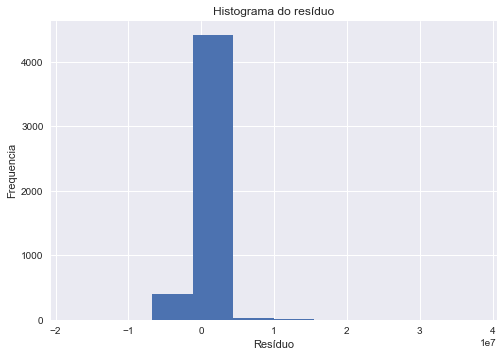

In [88]:
plt.hist(model_fit.resid)
plt.title("Histograma do resíduo")
plt.xlabel("Resíduo")
plt.ylabel("Frequencia")
plt.show()

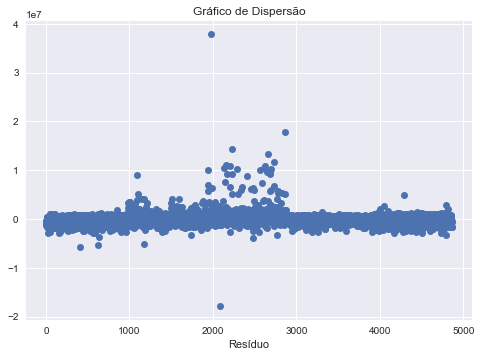

In [94]:
plt.plot(model_fit.resid, "o")
plt.title("Gráfico de Dispersão")
plt.xlabel("Resíduo")
plt.show()

### Modelo SciKit Learning

In [73]:
sk_model = linear_model.LinearRegression()
sk_model.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [81]:
sk_model.coef_

array([ -2.36498337e-01,  -4.88639506e+06,  -5.54258066e+06,
         1.50307649e+05,   1.93161536e+05,   1.09493803e+06,
         4.14587487e+05,   2.82612491e+05,  -1.78691024e+05,
         1.59193475e+05,  -1.09616545e+05,   7.16355540e+05,
        -1.31792298e+05,  -8.13471498e+04,  -1.56309670e+05,
         7.47352426e+04,  -1.72483547e+05,  -9.59426616e+04,
        -6.02931784e+04,  -9.11311984e+04,   9.98393147e+04,
         1.81928349e+05,   2.91710221e+05,  -2.99342971e+04,
         1.51824592e+05,  -1.43333350e+05,   1.17922769e+05,
        -1.76780104e+05,  -6.79571039e+04,  -1.00842224e+05,
        -8.76052817e+03,   1.23499295e+05,  -2.29281050e+05,
         5.37530195e+04,  -1.32405152e+05,   6.76836607e+04,
        -1.89708978e+04,  -8.55220361e+03,  -1.23931853e+05,
        -5.39669907e+04])